# NLP Project: Language Modeling Comparison
This notebook implements and compares three language models: **Bigram**, **Trigram**, and **Neural LSTM**.
It includes a unified preprocessing pipeline, training comparisons, and generation quality checks.


## 1. Setup and Imports


In [1]:
import re
import html
import string
import math
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from typing import List, Optional, Union

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Setup Visuals
sns.set_style("whitegrid")
%matplotlib inline

# Download resources if checks fail (quietly)
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
    
print("Libraries loaded.")



[nltk_data] Error loading punkt: <urlopen error [WinError 10054] An
[nltk_data]     existing connection was forcibly closed by the remote
[nltk_data]     host>


Libraries loaded.


## 2. Text Preprocessor Class


In [2]:
class TextPreprocessor:
    """
    A robust and professional preprocessing pipeline for NLP tasks.
    Designed to handle IMDB movie reviews for Classical, Neural, and Transformer models.
    """

    def __init__(self, 
                 remove_html: bool = True,
                 lowercase: bool = True,
                 remove_punctuation: bool = False,
                 remove_stopwords: bool = False,
                 lemmatize: bool = False,
                 expand_contractions: bool = True):
        """
        Initialize the pipeline with specific configuration flags.
        
        Args:
            remove_html (bool): Strip HTML tags (e.g., <br />). Default True.
            lowercase (bool): Convert text to lowercase. Default True.
            remove_punctuation (bool): Remove punctuation characters.
            remove_stopwords (bool): Remove standard English stopwords.
            lemmatize (bool): Apply WordNet lemmatization.
            expand_contractions (bool): Expand "isn't" to "is not".
        """
        self.remove_html = remove_html
        self.lowercase = lowercase
        self.remove_punctuation = remove_punctuation
        self.remove_stopwords = remove_stopwords
        self.lemmatize = lemmatize
        self.expand_contractions = expand_contractions

        # Pre-load resources to optimize runtime
        self.stop_words = set(stopwords.words('english'))
        self.stop_words.remove("not")
        self.lemmatizer = WordNetLemmatizer()
        
        # Simple contraction map for expansion
        self.contractions_dict = {
            "isn't": "is not", "aren't": "are not", "wasn't": "was not", "weren't": "were not",
            "haven't": "have not", "hasn't": "has not", "hadn't": "had not", "won't": "will not",
            "wouldn't": "would not", "don't": "do not", "doesn't": "does not", "didn't": "did not",
            "can't": "cannot", "couldn't": "could not", "shouldn't": "should not", "mightn't": "might not",
            "mustn't": "must not", "i'm": "i am", "you're": "you are", "he's": "he is", "she's": "she is",
            "it's": "it is", "we're": "we are", "they're": "they are", "i've": "i have", "you've": "you have",
            "we've": "we have", "they've": "they have", "i'll": "i will", "you'll": "you will",
            "he'll": "he will", "she'll": "she will", "we'll": "we will", "they'll": "they will"
        }
        self.contractions_re = re.compile('(%s)' % '|'.join(self.contractions_dict.keys()))

    def _clean_html(self, text: str) -> str:
        """Removes HTML tags and unescapes HTML entities."""
        text = html.unescape(text)
        # Regex for HTML tags
        clean = re.compile('<.*?>')
        return re.sub(clean, ' ', text)

    def _expand_contractions(self, text: str) -> str:
        """Expands common English contractions."""
        def replace(match):
            return self.contractions_dict[match.group(0)]
        return self.contractions_re.sub(replace, text)

    def _remove_punct(self, text: str) -> str:
        """
        Removes punctuation by replacing it with spaces.
        This prevents 'word,word' from becoming 'wordword'.
        """
        # Replace punctuation with a space
        return re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)

    def process_text(self, text: str) -> Union[str, List[str]]:
        """
        Main execution method. Applies enabled steps in the logical order.
        
        Returns:
            str: If the final output is a joined string.
            List[str]: If the processing flow ends in tokenization without re-joining.
        """
        if not isinstance(text, str) or not text:
            return ""

        # 1. Cleaning
        if self.remove_html:
            text = self._clean_html(text)
        
        # 2. Lowercasing
        if self.lowercase:
            text = text.lower()
            
        # 3. Expansion (must be after lowercasing for simple dict matching)
        if self.expand_contractions:
            text = self._expand_contractions(text)

        # 4. Punctuation Removal
        if self.remove_punctuation:
            text = self._remove_punct(text)

        # 5. Tokenization
        # We always tokenize to perform word-level operations (stopword/lemma)
        tokens = word_tokenize(text)

        # 6. Stopword Removal
        if self.remove_stopwords:
            tokens = [w for w in tokens if w not in self.stop_words]

        # 7. Lemmatization
        if self.lemmatize:
            tokens = [self.lemmatizer.lemmatize(w) for w in tokens]

        
        return " ".join(tokens)



## 3. Data Loading and Unified Preprocessing
We pre-process the dataset once for all models to ensure fair comparison and save time.
- **N-gram Corpus**: Lemmatized, punctuation kept (structural), contractions expanded.
- **Neural Corpus**: Lowercase, no lemmatization (learns forms), standard tokens.


In [3]:
# Load Data
try:
    df = pd.read_csv('IMDB Dataset.csv')
    raw_reviews = df['review'].tolist()
    print(f"Loaded {len(raw_reviews)} reviews.")
except FileNotFoundError:
    print("IMDB Dataset.csv not found. Using dummy data.")
    raw_reviews = ["The movie was terrible.", "I loved the film. It was great.", "The acting was bad."] * 100

# Configuration
SAMPLE_SIZE = len(raw_reviews)  
raw_reviews = raw_reviews[:SAMPLE_SIZE]

# 1. Pipeline for N-gram Models
print("Preprocessing for N-gram models...")
ngram_prep = TextPreprocessor(
    remove_html=True, 
    lowercase=True, 
    remove_punctuation=True, # Keep structure for n-grams
    remove_stopwords=False, 
    lemmatize=True, 
    expand_contractions=True
)

ngram_corpus = []
for r in raw_reviews:
    cleaned = ngram_prep.process_text(r)
    # Add start/end tokens. Bigram needs 1 start, Trigram needs 2. 
    # We will use 2 start tokens '<s>' '<s>' universally, Bigram can just ignore the extra one or we handle it in model.
    # To be safe and exact to class definitions, let's store as lists.
    tokens = cleaned.split()
    # Bigram expects ['<s>', w1...]
    # Trigram expects ['<s>', '<s>', w1...]
    # We'll store the clean text list and pad per model or creating a generic '<s>' '<s>' ... '</s>'
    tokens = ['<s>', '<s>'] + tokens + ['</s>']
    ngram_corpus.append(tokens)

# 2. Pipeline for Neural Model
print("Preprocessing for Neural models...")
neural_prep = TextPreprocessor(
    remove_html=True, 
    lowercase=True, 
    remove_punctuation=False,
    remove_stopwords=False, 
    lemmatize=False,
    expand_contractions=True
)

neural_corpus = []
MAX_LEN = 100
for r in raw_reviews:
    cleaned = neural_prep.process_text(r)
    tokens = cleaned.split()
    # Neural model logic from script: ['<s>'] + tokens + ['</s>']
    tokens = ['<s>'] + tokens[:MAX_LEN] + ['</s>']
    neural_corpus.append(tokens)

# Split (Sync split indices)
split_idx = int(len(raw_reviews) * 0.8)

train_ngram = ngram_corpus[:split_idx]
test_ngram  = ngram_corpus[split_idx:]

train_neural = neural_corpus[:split_idx]
test_neural  = neural_corpus[split_idx:]

print(f"Data ready. Train size: {len(train_ngram)}, Test size: {len(test_ngram)}")



Loaded 50000 reviews.
Preprocessing for N-gram models...
Preprocessing for Neural models...
Data ready. Train size: 40000, Test size: 10000


## 4. Model Definitions


### 4.1 Bigram Model


In [4]:
class BigramLanguageModel:
    def __init__(self, alpha=0.01):
        """
        Initialize the Bigram Model.
        
        Args:
            alpha (float): The smoothing parameter for Laplace smoothing. 
                           Default is 0.01.
        """
        self.alpha = alpha
        self.bigram_counts = defaultdict(lambda: defaultdict(int))
        self.unigram_counts = defaultdict(int)
        self.vocab = set()
        self.vocab_size = 0
        self.total_bigrams = 0
        self.total_unigrams = 0
        
        self.lambda1 = 0.3 # Unigram
        self.lambda2 = 0.7 # Bigram
        
    def train(self, corpus):
        """
        Trains the model on a corpus of tokenized sentences.
        Uses the full vocabulary (no <UNK> thresholding).
        """
        print("Training model on full vocabulary...")
        for sentence in corpus:
            # Update vocabulary and unigram counts
            for word in sentence:
                self.vocab.add(word)
                self.unigram_counts[word] += 1
                self.total_unigrams += 1
            
            # Update bigram counts
            for i in range(len(sentence) - 1):
                w_curr = sentence[i]
                w_next = sentence[i+1]
                self.bigram_counts[w_curr][w_next] += 1
                self.total_bigrams += 1
                
        self.vocab_size = len(self.vocab)
        print(f"Training complete. Vocab size: {self.vocab_size}")

    def get_probability(self, prev_word, word):
        """
        Calculates the interpolated probability P(word | prev_word).
        P = L2 * P(word|prev) + L1 * P(word)
        """
        # 1. Bigram Probability
        bigram_count = self.bigram_counts[prev_word][word]
        unigram_count_prev = self.unigram_counts[prev_word]
        
        p_bi_num = bigram_count + self.alpha
        p_bi_den = unigram_count_prev + (self.alpha * self.vocab_size)
        p_bi = p_bi_num / p_bi_den
        
        # 2. Unigram Probability
        unigram_count_word = self.unigram_counts[word]
        p_uni_num = unigram_count_word + self.alpha
        p_uni_den = self.total_unigrams + (self.alpha * self.vocab_size)
        p_uni = p_uni_num / p_uni_den
        
        return (self.lambda2 * p_bi) + (self.lambda1 * p_uni)

    def calculate_perplexity(self, test_corpus):
        """
        Calculates the perplexity of the model on a test corpus.
        """
        log_prob_sum = 0
        N = 0
        
        for sentence in test_corpus:
            for i in range(len(sentence) - 1):
                w_curr = sentence[i]
                w_next = sentence[i+1]
                
                # We do not replace with <UNK>. If a word is unknown,
                # get_probability handles it via smoothing.
                prob = self.get_probability(w_curr, w_next)
                
                log_prob_sum += math.log2(prob)
                N += 1
        
        if N == 0: return float('inf')
        
        avg_log_prob = -log_prob_sum / N
        perplexity = 2 ** avg_log_prob
        return perplexity

    def generate_sentence(self, max_length=20):
        """
        Generates a random sentence.
        """
        current_word = "<s>"
        sentence = [current_word]
        
        for _ in range(max_length):
            if current_word == "</s>":
                break
                
            # If current_word was never seen in training (e.g. from a user prompt),
            # unigram_count is 0. We fallback to uniform distribution or break.
            # Here we sample from the whole vocab if unknown, or just observed followers if known.
            
            possible_next = self.bigram_counts[current_word]
            
            if not possible_next:
                # Dead end or unknown word. 
                # Ideally: Sample uniformly from V (or weighted by unigrams).
                # For efficiency/simplicity here: break or pick random.
                break 

            candidates = list(possible_next.keys())
            counts = list(possible_next.values())
            
            next_word = random.choices(candidates, weights=counts, k=1)[0]
            
            sentence.append(next_word)
            current_word = next_word
            
        return " ".join(sentence[1:])

    def autocomplete(self, prompt, preprocessor, max_length=20):
        """
        Completes a given text prompt.
        """
        cleaned_prompt = preprocessor.process_text(prompt)
        tokens = cleaned_prompt.split()
        
        if not tokens:
            current_word = "<s>"
        else:
            current_word = tokens[-1]
            
        # Warning: If current_word is not in self.vocab, generation will stop immediately
        # because bigram_counts[current_word] will be empty.
        
        generated_tokens = []
        for _ in range(max_length):
            if current_word == "</s>":
                break
            
            possible_next = self.bigram_counts[current_word]
            
            if not possible_next:
                break
                
            candidates = list(possible_next.keys())
            counts = list(possible_next.values())
            
            next_word = random.choices(candidates, weights=counts, k=1)[0]
            
            generated_tokens.append(next_word)
            current_word = next_word
            
        return prompt + " " + " ".join(generated_tokens)

    def autocomplete(self, prompt, preprocessor, max_length=20):
        """
        Completes a given text prompt using the trained model.
        """
        # Preprocess the prompt to get the last token
        cleaned_prompt = preprocessor.process_text(prompt)
        tokens = cleaned_prompt.split()
        
        if not tokens:
            current_word = "<s>"
        else:
            current_word = tokens[-1]
            
        # Handle OOV for the seed word
        if current_word not in self.vocab:
            # Optionally print a warning or fallback
            current_word = "<UNK>"
            
        # Generate continuation
        generated_tokens = []
        for _ in range(max_length):
            if current_word == "</s>":
                break
            
            possible_next = self.bigram_counts[current_word]
            
            if not possible_next:
                # If we hit a dead end (should be rare with smoothing context, but possible if UNK), replace
                current_word = "<UNK>"
                possible_next = self.bigram_counts[current_word]

            if not possible_next:
                break
                
            candidates = list(possible_next.keys())
            counts = list(possible_next.values())
            
            next_word = random.choices(candidates, weights=counts, k=1)[0]
            
            generated_tokens.append(next_word)
            current_word = next_word
            
        return prompt + " " + " ".join(generated_tokens)
class SimpleBigramLanguageModel:
    def __init__(self, alpha=0.01):
        self.alpha = alpha
        self.bigram_counts = defaultdict(lambda: defaultdict(int))
        self.unigram_counts = defaultdict(int)
        self.vocab = set()
        self.vocab_size = 0
        
    def train(self, corpus):
        print("Training Simple Bigram on full vocabulary...")
        for sentence in corpus:
            for word in sentence:
                self.vocab.add(word)
                self.unigram_counts[word] += 1
            
            for i in range(len(sentence) - 1):
                w_curr = sentence[i]
                w_next = sentence[i+1]
                self.bigram_counts[w_curr][w_next] += 1
                
        self.vocab_size = len(self.vocab)
        print(f"Simple Bigram Training complete. Vocab size: {self.vocab_size}")

    def get_probability(self, prev_word, word):
        bigram_count = self.bigram_counts[prev_word][word]
        unigram_count_prev = self.unigram_counts[prev_word]
        
        num = bigram_count + self.alpha
        den = unigram_count_prev + (self.alpha * self.vocab_size)
        return num / den

    def calculate_perplexity(self, test_corpus):
        log_prob_sum = 0
        N = 0
        
        for sentence in test_corpus:
            for i in range(len(sentence) - 1):
                w_curr = sentence[i]
                w_next = sentence[i+1]
                prob = self.get_probability(w_curr, w_next)
                log_prob_sum += math.log2(prob)
                N += 1
        
        if N == 0: return float('inf')
        
        avg_log_prob = -log_prob_sum / N
        perplexity = 2 ** avg_log_prob
        return perplexity

    def generate_sentence(self, max_length=20):
        current_word = "<s>"
        sentence = [current_word]
        
        for _ in range(max_length):
            if current_word == "</s>":
                break
            possible_next = self.bigram_counts[current_word]
            if not possible_next:
                break 

            candidates = list(possible_next.keys())
            counts = list(possible_next.values())
            next_word = random.choices(candidates, weights=counts, k=1)[0]
            sentence.append(next_word)
            current_word = next_word
        return " ".join(sentence[1:])

    def autocomplete(self, prompt, preprocessor, max_length=20):
        cleaned_prompt = preprocessor.process_text(prompt)
        tokens = cleaned_prompt.split()
        if not tokens:
            current_word = "<s>"
        else:
            current_word = tokens[-1]
        if current_word not in self.vocab:
            current_word = "<UNK>"
            
        generated_tokens = []
        for _ in range(max_length):
            if current_word == "</s>":
                break
            possible_next = self.bigram_counts[current_word]
            if not possible_next:
                current_word = "<UNK>"
                possible_next = self.bigram_counts[current_word]
            if not possible_next:
                break
            candidates = list(possible_next.keys())
            counts = list(possible_next.values())
            next_word = random.choices(candidates, weights=counts, k=1)[0]
            generated_tokens.append(next_word)
            current_word = next_word
        return prompt + " " + " ".join(generated_tokens)


### 4.2 Trigram Model


In [5]:
class TrigramLanguageModel:
    def __init__(self, alpha=0.01):
        """
        Initialize the Trigram Model.
        
        Args:
            alpha (float): The smoothing parameter for Laplace smoothing. 
                           Default is 0.01.
        """
        self.alpha = alpha
        # trigram_counts: count of (w1, w2, w3) aka given w1, w2, what is w3?
        # Structure: dict[(w1, w2)] -> dict[w3] -> count
        self.trigram_counts = defaultdict(lambda: defaultdict(int))
        
        # bigram_counts: count of (w1, w2) as a history.
        # Structure: dict[(w1, w2)] -> count
        self.bigram_counts = defaultdict(int)
        self.unigram_counts = defaultdict(int)
        
        self.vocab = set()
        self.vocab_size = 0
        self.total_trigrams = 0
        self.total_unigrams = 0
        
        # Interpolation weights
        self.lambda1 = 0.1 # Unigram
        self.lambda2 = 0.3 # Bigram
        self.lambda3 = 0.6 # Trigram
        
    def train(self, corpus):
        """
        Trains the model on a corpus of tokenized sentences.
        """
        print("Training model on full vocabulary...")
        for sentence in corpus:
            # Update vocabulary and unigram counts
            for word in sentence:
                self.vocab.add(word)
                self.unigram_counts[word] += 1
                self.total_unigrams += 1
            
            # Update bigram counts (for backoff)
            for i in range(len(sentence) - 1):
                self.bigram_counts[(sentence[i], sentence[i+1])] += 1

            # Update trigram counts
            # Sentence is expected to be padded like ['<s>', '<s>', 'w1', ..., 'wn', '</s>']
            for i in range(len(sentence) - 2):
                w_1 = sentence[i]
                w_2 = sentence[i+1]
                w_3 = sentence[i+2]
                
                self.trigram_counts[(w_1, w_2)][w_3] += 1
                self.total_trigrams += 1
                
        self.vocab_size = len(self.vocab)
        print(f"Training complete. Vocab size: {self.vocab_size}")

    def get_probability(self, w_1, w_2, w_3):
        """
        Calculates the interpolated probability P(w_3 | w_1, w_2).
        P = L3 * P(w3|w1,w2) + L2 * P(w3|w2) + L1 * P(w3)
        """
        # 1. Trigram Probability
        trigram_count = self.trigram_counts[(w_1, w_2)][w_3]
        bigram_context_count = self.bigram_counts[(w_1, w_2)]
        
        p_tri_num = trigram_count + self.alpha
        p_tri_den = bigram_context_count + (self.alpha * self.vocab_size)
        p_tri = p_tri_num / p_tri_den
        
        # 2. Bigram Probability (Backoff)
        bigram_count = self.bigram_counts[(w_2, w_3)]
        unigram_context_count = self.unigram_counts[w_2]
        
        p_bi_num = bigram_count + self.alpha
        p_bi_den = unigram_context_count + (self.alpha * self.vocab_size)
        p_bi = p_bi_num / p_bi_den
        
        # 3. Unigram Probability
        unigram_count = self.unigram_counts[w_3]
        p_uni_num = unigram_count + self.alpha
        p_uni_den = self.total_unigrams + (self.alpha * self.vocab_size)
        p_uni = p_uni_num / p_uni_den
        
        return (self.lambda3 * p_tri) + (self.lambda2 * p_bi) + (self.lambda1 * p_uni)

    def calculate_perplexity(self, test_corpus):
        """
        Calculates the perplexity of the model on a test corpus.
        """
        log_prob_sum = 0
        N = 0
        
        for sentence in test_corpus:
            for i in range(len(sentence) - 2):
                w_1 = sentence[i]
                w_2 = sentence[i+1]
                w_3 = sentence[i+2]
                
                prob = self.get_probability(w_1, w_2, w_3)
                
                log_prob_sum += math.log2(prob)
                N += 1
        
        if N == 0: return float('inf')
        
        avg_log_prob = -log_prob_sum / N
        perplexity = 2 ** avg_log_prob
        return perplexity

    def generate_sentence(self, max_length=20):
        """
        Generates a random sentence.
        """
        # Start with two padding tokens
        current_w1 = "<s>"
        current_w2 = "<s>"
        sentence = [current_w1, current_w2]
        
        for _ in range(max_length):
            # If we generated the end token, stop
            if current_w2 == "</s>":
                break
                
            possible_next = self.trigram_counts[(current_w1, current_w2)]
            
            if not possible_next:
                # If unknown history, we can't progress. 
                break 

            candidates = list(possible_next.keys())
            counts = list(possible_next.values())
            
            next_word = random.choices(candidates, weights=counts, k=1)[0]
            
            sentence.append(next_word)
            current_w1 = current_w2
            current_w2 = next_word
            
        # Return joined sentence, removing start tokens
        # Typically we don't show <s> <s>
        # The list has ['<s>', '<s>', 'word1', ... '</s>' maybe]
        # We can strip the first two <s>
        return " ".join(sentence[2:])

    def autocomplete(self, prompt, preprocessor, max_length=20):
        """
        Completes a given text prompt using the trained model.
        """
        cleaned_prompt = preprocessor.process_text(prompt)
        tokens = cleaned_prompt.split()
        
        # Determine context words (need 2)
        if len(tokens) >= 2:
            current_w1 = tokens[-2]
            current_w2 = tokens[-1]
        elif len(tokens) == 1:
            current_w1 = "<s>"
            current_w2 = tokens[-1]
        else:
            current_w1 = "<s>"
            current_w2 = "<s>"
            
        # Handle OOV - simplistic approach, similar to bigram fallbacks could be added, 
        # but here we rely on smoothing or break if empty.
        
        generated_tokens = []
        for _ in range(max_length):
            if current_w2 == "</s>":
                break
            
            possible_next = self.trigram_counts[(current_w1, current_w2)]
            
            if not possible_next:
                # If we dead end, we could maybe try fallback to bigram?
                # But for strict trigram implementation request:
                break
                
            candidates = list(possible_next.keys())
            counts = list(possible_next.values())
            
            next_word = random.choices(candidates, weights=counts, k=1)[0]
            
            generated_tokens.append(next_word)
            current_w1 = current_w2
            current_w2 = next_word
            
        return prompt + " " + " ".join(generated_tokens)
class SimpleTrigramLanguageModel:
    def __init__(self, alpha=0.01):
        self.alpha = alpha
        self.trigram_counts = defaultdict(lambda: defaultdict(int))
        self.bigram_counts = defaultdict(int)
        self.vocab = set()
        self.vocab_size = 0
        
    def train(self, corpus):
        print("Training Simple Trigram on full vocabulary...")
        for sentence in corpus:
            for word in sentence:
                self.vocab.add(word)
            
            for i in range(len(sentence) - 1):
                self.bigram_counts[(sentence[i], sentence[i+1])] += 1

            for i in range(len(sentence) - 2):
                w_1 = sentence[i]
                w_2 = sentence[i+1]
                w_3 = sentence[i+2]
                self.trigram_counts[(w_1, w_2)][w_3] += 1
                
        self.vocab_size = len(self.vocab)
        print(f"Simple Trigram Training complete. Vocab size: {self.vocab_size}")

    def get_probability(self, w_1, w_2, w_3):
        trigram_count = self.trigram_counts[(w_1, w_2)][w_3]
        bigram_context_count = self.bigram_counts[(w_1, w_2)]
        
        num = trigram_count + self.alpha
        den = bigram_context_count + (self.alpha * self.vocab_size)
        return num / den

    def calculate_perplexity(self, test_corpus):
        log_prob_sum = 0
        N = 0
        
        for sentence in test_corpus:
            for i in range(len(sentence) - 2):
                w_1 = sentence[i]
                w_2 = sentence[i+1]
                w_3 = sentence[i+2]
                prob = self.get_probability(w_1, w_2, w_3)
                log_prob_sum += math.log2(prob)
                N += 1
        
        if N == 0: return float('inf')
        
        avg_log_prob = -log_prob_sum / N
        perplexity = 2 ** avg_log_prob
        return perplexity

    def generate_sentence(self, max_length=20):
        current_w1 = "<s>"
        current_w2 = "<s>"
        sentence = [current_w1, current_w2]
        
        for _ in range(max_length):
            if current_w2 == "</s>":
                break
            possible_next = self.trigram_counts[(current_w1, current_w2)]
            if not possible_next:
                # If unknown history, break 
                break 

            candidates = list(possible_next.keys())
            counts = list(possible_next.values())
            next_word = random.choices(candidates, weights=counts, k=1)[0]
            sentence.append(next_word)
            current_w1 = current_w2
            current_w2 = next_word
            
        return " ".join(sentence[2:])

    def autocomplete(self, prompt, preprocessor, max_length=20):
        cleaned_prompt = preprocessor.process_text(prompt)
        tokens = cleaned_prompt.split()
        if len(tokens) >= 2:
            current_w1 = tokens[-2]
            current_w2 = tokens[-1]
        elif len(tokens) == 1:
            current_w1 = "<s>"
            current_w2 = tokens[-1]
        else:
            current_w1 = "<s>"
            current_w2 = "<s>"
        generated_tokens = []
        for _ in range(max_length):
            if current_w2 == "</s>":
                break
            possible_next = self.trigram_counts[(current_w1, current_w2)]
            if not possible_next:
                break
            candidates = list(possible_next.keys())
            counts = list(possible_next.values())
            next_word = random.choices(candidates, weights=counts, k=1)[0]
            generated_tokens.append(next_word)
            current_w1 = current_w2
            current_w2 = next_word
        return prompt + " " + " ".join(generated_tokens)


### 4.3 Neural Model (LSTM)


In [6]:
class Vocabulary:
    def __init__(self, token_to_idx=None):
        if token_to_idx:
            self.token_to_idx = token_to_idx
        else:
            self.token_to_idx = {"<PAD>": 0, "<UNK>": 1, "<s>": 2, "</s>": 3}
        self.idx_to_token = {v: k for k, v in self.token_to_idx.items()}
        
    def build_vocab(self, sentences, min_freq=2):
        print("Building vocabulary...")
        all_tokens = [token for sent in sentences for token in sent]
        counts = Counter(all_tokens)
        
        for token, count in counts.items():
            if count >= min_freq and token not in self.token_to_idx:
                self.token_to_idx[token] = len(self.token_to_idx)
                
        self.idx_to_token = {v: k for k, v in self.token_to_idx.items()}
        print(f"Vocabulary size: {len(self.token_to_idx)}")
        
    def __len__(self):
        return len(self.token_to_idx)
    
    def stoi(self, token):
        return self.token_to_idx.get(token, self.token_to_idx["<UNK>"])
        
    def itos(self, idx):
        return self.idx_to_token.get(idx, "<UNK>")

class IMDBDataset(Dataset):
    def __init__(self, sentences, vocab):
        self.sentences = sentences
        self.vocab = vocab
        
    def __len__(self):
        return len(self.sentences)
        
    def __getitem__(self, idx):
        tokenized_sent = self.sentences[idx]
        # Numericalize
        indexed = [self.vocab.stoi(t) for t in tokenized_sent]
        return torch.tensor(indexed, dtype=torch.long)

def collate_fn(batch):
    """
    Custom collate function to handle variable length sentences via padding.
    """
    # batch is a list of tensors
    # Sort by length (descending) for pack_padded_sequence
    batch.sort(key=lambda x: len(x), reverse=True)
    
    # Separate source and target
    # Source: <s> w1 w2 ... wn
    # Target: w1 w2 ... wn </s>
    
    inputs = [item[:-1] for item in batch]
    targets = [item[1:] for item in batch]
    
    lengths = torch.tensor([len(x) for x in inputs], dtype=torch.long)
    
    # Pad sequences
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=0)
    
    return inputs_padded, targets_padded, lengths

class NeuralLM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(NeuralLM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x, lengths=None, hidden=None):
        # x: (batch, seq_len)
        embed = self.embedding(x) # (batch, seq_len, embed_dim)
        
        if lengths is not None:
            # Pack
            packed_embed = pack_padded_sequence(embed, lengths.cpu(), batch_first=True, enforce_sorted=True)
            packed_out, hidden = self.lstm(packed_embed, hidden)
            # Unpack
            output, _ = pad_packed_sequence(packed_out, batch_first=True)
        else:
            # No packing (e.g. inference)
            output, hidden = self.lstm(embed, hidden)
            
        # output: (batch, seq_len, hidden_dim) (padded where needed)
        
        logits = self.fc(output) # (batch, seq_len, vocab_size)
        return logits, hidden

def generate_text(model, vocab, start_prompt="The movie", max_len=20, device='cpu', temperature=1.0):
    model.eval()
    preprocessor = TextPreprocessor(lowercase=True)
    tokens = preprocessor.process_text(start_prompt).split()
    
    current_idx = [vocab.stoi(t) for t in tokens]
    # Add start token if not present logic? 
    # The model trained on <s>... so prompt should ideally start with something logical.
    # If we feed "The movie", it's mid-sentence-ish.
    
    input_seq = torch.tensor(current_idx, dtype=torch.long).unsqueeze(0).to(device) # (1, seq_len)
    
    generated = list(tokens)
    
    hidden = None
    
    with torch.no_grad():
        for _ in range(max_len):
            logits, hidden = model(input_seq, hidden=hidden)
            
            # Get last time step
            last_logits = logits[0, -1, :]
            
            # Apply temperature
            if temperature != 1.0:
                last_logits = last_logits / temperature
                
            probs = torch.softmax(last_logits, dim=0)
            
            # Sample
            next_token_idx = torch.multinomial(probs, 1).item()
            next_token = vocab.itos(next_token_idx)
            
            if next_token == "</s>":
                break
                
            generated.append(next_token)
            
            # Next input is the single token we just generated (feeding back one by one)
            # Or we could feed the whole sequence, but feeding 1 is efficient IF we keep hidden state.
            input_seq = torch.tensor([[next_token_idx]], dtype=torch.long).to(device)
            
    return " ".join(generated)


## 5. Comparison: Bigram vs Trigram
We compare the perplexity and generation quality of the statistical models.


In [7]:

# Initialize
bigram_model = BigramLanguageModel(alpha=0.01)
simple_bigram_model = SimpleBigramLanguageModel(alpha=0.01)
trigram_model = TrigramLanguageModel(alpha=0.01)
simple_trigram_model = SimpleTrigramLanguageModel(alpha=0.01)

# Train Bigram
print("Training Bigram...")
start = time.time()
train_bi_adapted = [s[1:] for s in train_ngram] 
test_bi_adapted = [s[1:] for s in test_ngram]
bigram_model.train(train_bi_adapted)
bigram_time = time.time() - start
print(f"Bigram Trained in {bigram_time:.4f}s")

# Train Simple Bigram
print("Training Simple Bigram...")
start = time.time()
simple_bigram_model.train(train_bi_adapted)
simple_bigram_time = time.time() - start
print(f"Simple Bigram Trained in {simple_bigram_time:.4f}s")

# Train Trigram
print("Training Trigram...")
start = time.time()
trigram_model.train(train_ngram)
trigram_time = time.time() - start
print(f"Trigram Trained in {trigram_time:.4f}s")

# Train Simple Trigram
print("Training Simple Trigram...")
start = time.time()
simple_trigram_model.train(train_ngram)
simple_trigram_time = time.time() - start
print(f"Simple Trigram Trained in {simple_trigram_time:.4f}s")

# Perplexity
pp_bi = bigram_model.calculate_perplexity(test_bi_adapted)
pp_simple_bi = simple_bigram_model.calculate_perplexity(test_bi_adapted)
pp_tri = trigram_model.calculate_perplexity(test_ngram)
pp_simple_tri = simple_trigram_model.calculate_perplexity(test_ngram)

print(f"\nBigram Perplexity: {pp_bi:.2f}")
print(f"Simple Bigram Perplexity: {pp_simple_bi:.2f}")
print(f"Trigram Perplexity: {pp_tri:.2f}")
print(f"Simple Trigram Perplexity: {pp_simple_tri:.2f}")

# Generation Comparison
print("\n--- Generation Comparison (Unprompted) ---")
print("Bigram:")
for i in range(2):
    print(f"  {i+1}. {bigram_model.generate_sentence()}")
print("Simple Bigram:")
for i in range(2):
    print(f"  {i+1}. {simple_bigram_model.generate_sentence()}")

print("\nTrigram:")
for i in range(2):
    print(f"  {i+1}. {trigram_model.generate_sentence()}")
print("Simple Trigram:")
for i in range(2):
    print(f"  {i+1}. {simple_trigram_model.generate_sentence()}")



Training Bigram...
Training model on full vocabulary...
Training complete. Vocab size: 84589
Bigram Trained in 11.1138s
Training Simple Bigram...
Training Simple Bigram on full vocabulary...
Simple Bigram Training complete. Vocab size: 84589
Simple Bigram Trained in 8.6424s
Training Trigram...
Training model on full vocabulary...
Training complete. Vocab size: 84589
Trigram Trained in 28.7869s
Training Simple Trigram...
Training Simple Trigram on full vocabulary...
Simple Trigram Training complete. Vocab size: 84589
Simple Trigram Trained in 23.9890s

Bigram Perplexity: 363.91
Simple Bigram Perplexity: 450.83
Trigram Perplexity: 465.57
Simple Trigram Perplexity: 2985.33

--- Generation Comparison (Unprompted) ---
Bigram:
  1. with sharky look impressive avant garde crowd scene and can superman in another problem giving up for columbia whose sexual
  2. this show of time this because i did some thing one of those who us the unwittingly aided and often
Simple Bigram:
  1. this movie to g

## 6. Comprehensive Comparison (LSTM vs N-grams)
Comparing Logic, Training Time, and Perplexity across all three architectures.


In [8]:

# Train Neural Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training Neural Model on {device}...")

# Config
EMBED_DIM = 64
HIDDEN_DIM = 512
BATCH_SIZE = 64
LEARNING_RATE = 0.005
NUM_EPOCHS = 6 

# Setup
vocab = Vocabulary()
vocab.build_vocab(train_neural, min_freq=2) # => lowers perplexity and decreases train time
dataset = IMDBDataset(train_neural, vocab)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

model_lstm = NeuralLM(len(vocab), EMBED_DIM, HIDDEN_DIM).to(device)
optimizer = optim.Adam(model_lstm.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# Training Loop
start = time.time()
model_lstm.train()
loss_history = []

print(f"Starting Training. ")
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    for inputs, targets, lengths in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        logits, _ = model_lstm(inputs, lengths)
        loss = criterion(logits.view(-1, len(vocab)), targets.view(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    navg = epoch_loss / len(dataloader)
    loss_history.append(navg)
    print(f"Epoch {epoch+1}: Loss {navg:.4f}")

neural_time = time.time() - start
print(f"Neural Trained in {neural_time:.4f}s")

# Neural Perplexity (Approximate on Test Set)
test_ds = IMDBDataset(test_neural, vocab)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)
model_lstm.eval()
total_n_loss = 0
total_batches = 0
with torch.no_grad():
    for inputs, targets, lengths in test_dl:
        inputs, targets = inputs.to(device), targets.to(device)
        logits, _ = model_lstm(inputs, lengths)
        # Loss per batch
        loss = criterion(logits.view(-1, len(vocab)), targets.view(-1))
        total_n_loss += loss.item()
        total_batches += 1

avg_test_loss = total_n_loss / total_batches if total_batches > 0 else 999
pp_neural = math.exp(avg_test_loss)
print(f"Neural Perplexity: {pp_neural:.2f}")



Training Neural Model on cuda...
Building vocabulary...
Vocabulary size: 40253
Starting Training. 
Epoch 1: Loss 5.4724
Epoch 2: Loss 4.7405
Epoch 3: Loss 4.4291
Epoch 4: Loss 4.2026
Epoch 5: Loss 4.0246
Epoch 6: Loss 3.8792
Neural Trained in 350.6895s
Neural Perplexity: 136.08


### 6.1 Performance Visualization


C:\Users\vogle\AppData\Local\Temp\ipykernel_38088\999618731.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=times, ax=axes[0], palette="viridis")
C:\Users\vogle\AppData\Local\Temp\ipykernel_38088\999618731.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=perplexities, ax=axes[1], palette="magma")


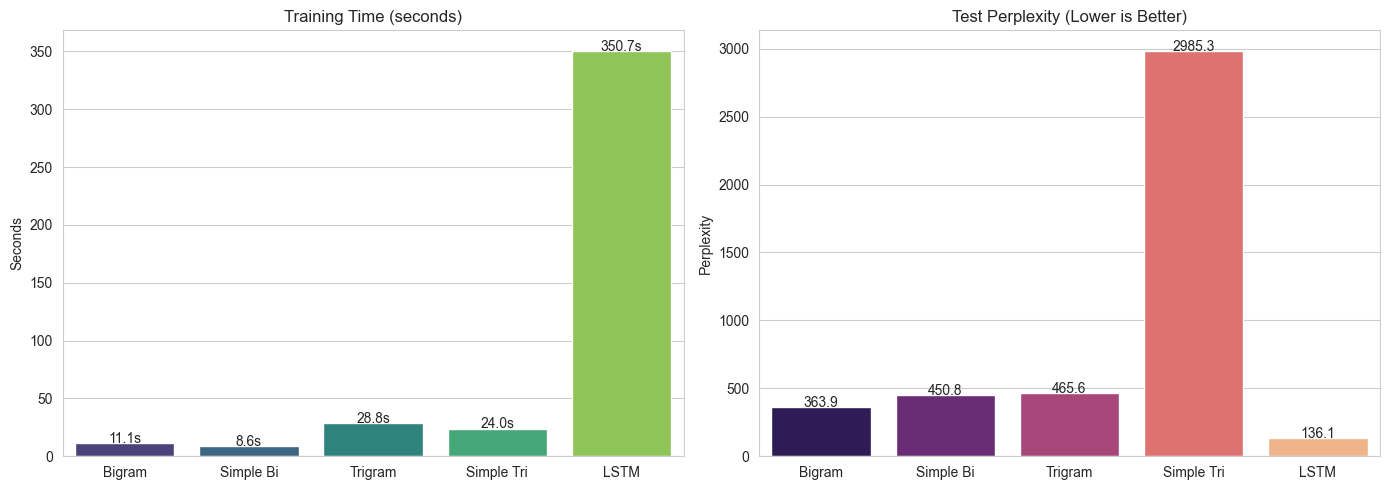

In [9]:

models = ['Bigram', 'Simple Bi', 'Trigram', 'Simple Tri', 'LSTM']
times = [bigram_time, simple_bigram_time, trigram_time, simple_trigram_time, neural_time]
perplexities = [pp_bi, pp_simple_bi, pp_tri, pp_simple_tri, pp_neural]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time Plot
sns.barplot(x=models, y=times, ax=axes[0], palette="viridis")
axes[0].set_title("Training Time (seconds)")
axes[0].set_ylabel("Seconds")
for i, v in enumerate(times):
    axes[0].text(i, v + 0.1, f"{v:.1f}s", ha='center')

# Perplexity Plot
sns.barplot(x=models, y=perplexities, ax=axes[1], palette="magma")
axes[1].set_title("Test Perplexity (Lower is Better)")
axes[1].set_ylabel("Perplexity")
for i, v in enumerate(perplexities):
    axes[1].text(i, v + 1, f"{v:.1f}", ha='center')

plt.tight_layout()
plt.show()



## 7. Qualitative Comparison: Text Generation
Comparing outputs with and without prompts.


In [10]:

prompts = [None, "The movie was", "I thought that"]

def get_continuation(model_type, prompt):
    if prompt is None:
        if model_type == 'LSTM':
            return generate_text(model_lstm, vocab, "The", device=device)
        elif model_type == 'Bigram':
            return bigram_model.generate_sentence()
        elif model_type == 'Simple Bi':
            return simple_bigram_model.generate_sentence()
        elif model_type == 'Trigram':
            return trigram_model.generate_sentence()
        elif model_type == 'Simple Tri':
            return simple_trigram_model.generate_sentence()
    else:
        # Prompted
        if model_type == 'LSTM':
            return generate_text(model_lstm, vocab, prompt, device=device)
        elif model_type == 'Bigram':
            return bigram_model.autocomplete(prompt, ngram_prep)
        elif model_type == 'Simple Bi':
            return simple_bigram_model.autocomplete(prompt, ngram_prep)
        elif model_type == 'Trigram':
            return trigram_model.autocomplete(prompt, ngram_prep)
        elif model_type == 'Simple Tri':
            return simple_trigram_model.autocomplete(prompt, ngram_prep)

results = []
for p in prompts:
    p_label = p if p else "Unprompted"
    row = {"Prompt": p_label}
    row["Bigram"] = get_continuation('Bigram', p)
    row["Simple Bi"] = get_continuation('Simple Bi', p)
    row["Trigram"] = get_continuation('Trigram', p)
    row["Simple Tri"] = get_continuation('Simple Tri', p)
    row["LSTM"] = get_continuation('LSTM', p)
    results.append(row)

res_df = pd.DataFrame(results)
pd.set_option('display.max_colwidth', None)
display(res_df)



,Prompt,Bigram,Simple Bi,Trigram,Simple Tri,LSTM
0,Unprompted,the story about the movie where she transforms the selling movie could not dehumanize and hong sang to go by,you flirting with plot it back after somebody would rather than spinal tap i have any other film wa written,i have always enjoyed film like this show is the big screen and about real event very well the local,if there would have had in recapturing the humor is great love story bird and a bunch of garbage thomas,the phone rings best was dubbed and did
1,The movie was,The movie was everybody on the same time watching it a tough guy lost originally going back to russell is a total lack,The movie was lucky luke wilson meet plump balding william phipps a a the script to dance in bringing an awesome in the,The movie was a pretty poor </s>,The movie was being torn by war and went without any muscle power although he quietly nail the actual job while hank plan,"the movie was so empty , and inane scene where chinese cop eddy presents bear down the past few years of the"
2,I thought that,I thought that go check it suck up the series at the u s show the first section of the only one of,I thought that but is a movie nobody involved in 1992 and crook who knew he is due to death star animated it,I thought that myrna loy fred derry upon returning the film wa frank sinatra and he just say it can get arthritis in,I thought that tim curry and ernie three rich youth who have actually been a lifetime you have the choice of actor who,i thought that this might be a fine example of what jackie chan has given him career
